In [1]:
!pip install albumentations imgaug

In [2]:
!pip install --force-reinstall opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.9.0.80
    Uninstalling opencv-python-4.9.0.80:
      Successfully uninstalled opencv-python-4.9.0.80


In [3]:
!apt-get install -y libgl1-mesa-glx libglib2.0.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libglib2.0-0-dbg' for regex 'libglib2.0.0'
Note, selecting 'libglib2.0-0' for regex 'libglib2.0.0'
libglib2.0-0 is already the newest version (2.72.4-0ubuntu2.2).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import scipy.io as sio
import imgaug.augmenters as iaa
import numpy as np
import os
from torch import optim
from torchvision.transforms import Resize, Compose
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import albumentations as A
from torchvision.transforms.functional import resize
#%env CUDA_LAUNCH_BLOCKING=1

In [5]:
class DualTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img, mask):
        return self.transform(img), self.transform(mask)

In [6]:
from torchvision import transforms
import skimage.transform as sk_transform

class LizardDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_list = os.listdir(img_dir)
        self.label_list = os.listdir(label_dir)
        self.transform = transform

         # Load and preprocess the first image to calculate mean and std
        first_img_path = os.path.join(self.img_dir, self.img_list[0])
        first_img = Image.open(first_img_path).convert('RGB')
        self.mean, self.std = self.calculate_mean_std(first_img)

        # Define the color normalization transform
        self.color_norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean, std=self.std)
        ])


    def calculate_mean_std(self, img):
        img_array = np.array(img) / 255.0 
        mean = np.mean(img_array, axis=(0, 1))
        std = np.std(img_array, axis=(0, 1))
        return mean.tolist(), std.tolist()

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.img_dir, self.img_list[idx])
        img = Image.open(img_path)

        img = self.color_norm(img)
        
        # Apply transforms if any
        if self.transform:
            img = self.transform(img)

        label_path = os.path.join(self.label_dir, self.label_list[idx])
        # Load label
        label = sio.loadmat(label_path)


        inst_map = label['inst_map']
        nuclei_id = label['id']
        classes = label['class']
        
        # Define function to create class map
        def create_class_map(inst_map, nuclei_id, classes):
            class_map = np.zeros_like(inst_map) 
            nuclei_id_list = np.squeeze(nuclei_id).tolist()
            for inst_id, class_id in zip(nuclei_id_list, classes):
                class_map[inst_map == inst_id] = class_id
            return class_map

        # Create class map
        class_map = create_class_map(inst_map, nuclei_id, classes)
        class_map = sk_transform.resize(class_map, (img.shape[1], img.shape[2]), anti_aliasing=False, order=0, preserve_range=True)
        
        sample = {'image': img, 'inst_map': class_map}
        return sample
        
    def visualize_segmentation_map(self, idx):
        sample = self.__getitem__(idx)
        inst_map = sample['inst_map']

        plt.imshow(inst_map)
        plt.title('Instance Segmentation Map')
        plt.colorbar()
        plt.show()

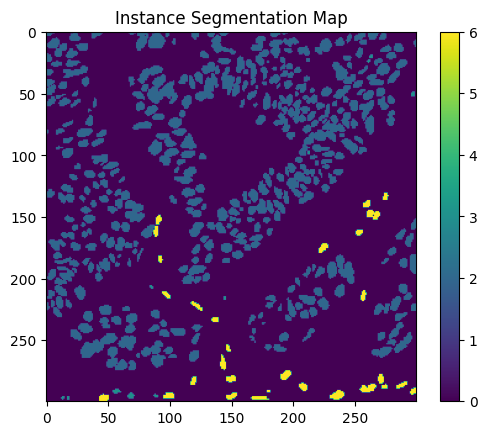

In [7]:
# Create a dataset
img_transforms = transforms.Compose([
    transforms.Resize((300, 300)), 
])

full_dataset = LizardDataset(img_dir='../data/lizard', label_dir='../data/labels', transform=img_transforms)
full_dataset.visualize_segmentation_map(0)
# Calculate lengths of splits
total_len = len(full_dataset)
train_len = int(0.8 * total_len)
valid_len = int(0.1 * total_len)
test_len = total_len - train_len - valid_len

# Splitting the dataset
train_data, val_data, test_data = random_split(full_dataset, lengths=[train_len, valid_len, test_len])

# Loading the datasets into dataloader
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:


def double_convolution(in_channels, out_channels):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op


def crop_tensor(src_tensor, target_tensor):
    target_size = target_tensor.size()[2:]
    src_size = src_tensor.size()[2:]
    crop_left = (src_size[1] - target_size[1]) // 2
    crop_top = (src_size[0] - target_size[0]) // 2
    return src_tensor[..., crop_top:crop_top + target_size[0], crop_left:crop_left + target_size[1]]


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        
        self.up_transpose_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=2, stride=2)
        self.up_convolution_1 = double_convolution(512, 256)
        
        self.up_transpose_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=2, stride=2)
        self.up_convolution_2 = double_convolution(256, 128)
        
        self.up_transpose_3 = nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2, stride=2)
        self.up_convolution_3 = double_convolution(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1) 

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)

        up_1 = self.up_transpose_1(down_7)
        down_5 = crop_tensor(down_5, up_1)
        x = self.up_convolution_1(torch.cat([down_5, up_1], 1))
        up_2 = self.up_transpose_2(x)
        down_3 = crop_tensor(down_3, up_2)
        x = self.up_convolution_2(torch.cat([down_3, up_2], 1))
        up_3 = self.up_transpose_3(x)
        down_1 = crop_tensor(down_1, up_3)
        x = self.up_convolution_3(torch.cat([down_1, up_3], 1))
        out = self.out(x)
        return out

In [9]:


def double_convolution_dilated(in_channels, out_channels):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,dilation=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,dilation=2),
        nn.ReLU(inplace=True)
    )
    return conv_op


class DilatedUNet(nn.Module):
    def __init__(self, num_classes):
        super(DilatedUNet, self).__init__()
        self.num_classes = num_classes
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_convolution_1 = double_convolution_dilated(3, 64)
        self.down_convolution_2 = double_convolution_dilated(64, 128)
        self.down_convolution_3 = double_convolution_dilated(128, 256)
        self.down_convolution_4 = double_convolution_dilated(256, 512)

        
        self.up_transpose_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=2,stride=2)
        self.up_convolution_1 = double_convolution_dilated(512, 256)
        
        self.up_transpose_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=2, stride=2)
        self.up_convolution_2 = double_convolution_dilated(256, 128)
        
        self.up_transpose_3 = nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2, stride=2)
        self.up_convolution_3 = double_convolution_dilated(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1) 

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)

        up_1 = self.up_transpose_1(down_7)
        down_5 = crop_tensor(down_5, up_1)
        x = self.up_convolution_1(torch.cat([down_5, up_1], 1))
        up_2 = self.up_transpose_2(x)
        down_3 = crop_tensor(down_3, up_2)
        x = self.up_convolution_2(torch.cat([down_3, up_2], 1))
        up_3 = self.up_transpose_3(x)
        down_1 = crop_tensor(down_1, up_3)
        x = self.up_convolution_3(torch.cat([down_1, up_3], 1))
        out = self.out(x)
        return out

In [10]:
def dice_score(outputs, labels):
    smooth = 1e-6
    outputs = torch.sigmoid(outputs)
    intersection = torch.sum(outputs * labels)
    union = torch.sum(outputs) + torch.sum(labels)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def dice_coefficient(outputs, labels):
    smooth = 1e-6
    intersection = torch.sum(outputs * labels)
    union = torch.sum(outputs) + torch.sum(labels)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def iou(outputs, labels):
    smooth = 1e-6
    intersection = torch.sum(outputs * labels)
    union = torch.sum(outputs) + torch.sum(labels) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def train_model(model, train_loader, val_loader, num_epochs=4, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        total_train = 0
        for i, batch in enumerate(train_loader):
            inputs = batch['image'].to(device)
            labels = batch['inst_map']
            
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = F.interpolate(labels.unsqueeze(1).float(), size=outputs.shape[2:]).long().squeeze(1).to(device)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)

            # Calculate Dice and IoU
            outputs_binary = torch.argmax(outputs, dim=1)
            train_dice += dice_coefficient(outputs_binary, labels)
            train_iou += iou(outputs_binary, labels)

            # Calculate batch-wise accuracy
            batch_accuracy = (predicted_train == labels).sum().item() / labels.size(0)

            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, Batch Acc: {batch_accuracy:.4f}")
            
        # Calculate train loss and metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['image'].to(device)
                labels = batch['inst_map'].to(device)

                outputs = model(inputs)
                labels = F.interpolate(labels.unsqueeze(1).float(), size=outputs.shape[2:]).long().squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted_val = torch.max(outputs, 1)
                total_val += labels.size(0)

                # Calculate Dice and IoU
                outputs_binary = torch.argmax(outputs, dim=1)
                val_dice += dice_coefficient(outputs_binary, labels)
                val_iou += iou(outputs_binary, labels)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)

        # Store losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Train IoU: {avg_train_iou:.4f}, Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}, Val IoU: {avg_val_iou:.4f}")
        
    print("Training complete.")

    # Plotting
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()


Training Dilated UNet model...
Epoch 1/4, Batch 1/6, Loss: 1.9287, Batch Acc: 80.0625
Epoch 1/4, Batch 2/6, Loss: 1.8270, Batch Acc: 36925.2500
Epoch 1/4, Batch 3/6, Loss: 1.6300, Batch Acc: 38527.6250
Epoch 1/4, Batch 4/6, Loss: 0.8889, Batch Acc: 36697.9688
Epoch 1/4, Batch 5/6, Loss: 0.8019, Batch Acc: 37045.9375
Epoch 1/4, Batch 6/6, Loss: 0.8927, Batch Acc: 37054.9333
Epoch 1/4, Train Loss: 1.3282, Train Dice: 0.1320, Train IoU: 0.1086, Val Loss: 0.7929, Val Dice: 0.0000, Val IoU: 0.0000
Epoch 2/4, Batch 1/6, Loss: 0.7805, Batch Acc: 37614.9688
Epoch 2/4, Batch 2/6, Loss: 0.6797, Batch Acc: 37222.6562
Epoch 2/4, Batch 3/6, Loss: 0.8142, Batch Acc: 36590.0938
Epoch 2/4, Batch 4/6, Loss: 0.7078, Batch Acc: 37512.1250
Epoch 2/4, Batch 5/6, Loss: 0.7130, Batch Acc: 37176.4375
Epoch 2/4, Batch 6/6, Loss: 0.6637, Batch Acc: 37494.7000
Epoch 2/4, Train Loss: 0.7265, Train Dice: 0.0000, Train IoU: 0.0000, Val Loss: 0.6891, Val Dice: 0.0000, Val IoU: 0.0000
Epoch 3/4, Batch 1/6, Loss: 0.67

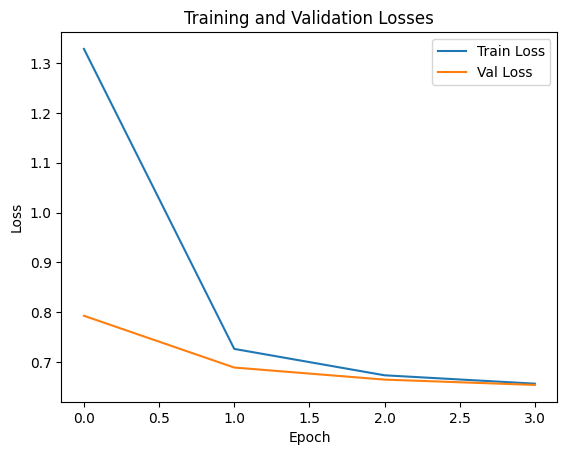

Training UNet model...
Epoch 1/4, Batch 1/6, Loss: 1.9599, Batch Acc: 322.3438
Epoch 1/4, Batch 2/6, Loss: 1.8274, Batch Acc: 70975.7188
Epoch 1/4, Batch 3/6, Loss: 1.4817, Batch Acc: 72196.6250
Epoch 1/4, Batch 4/6, Loss: 1.1428, Batch Acc: 74725.5938
Epoch 1/4, Batch 5/6, Loss: 1.0508, Batch Acc: 71886.8750
Epoch 1/4, Batch 6/6, Loss: 1.0156, Batch Acc: 71772.0667
Epoch 1/4, Train Loss: 1.4130, Train Dice: 0.1872, Train IoU: 0.1609, Val Loss: 0.8334, Val Dice: 0.0000, Val IoU: 0.0000
Epoch 2/4, Batch 1/6, Loss: 0.8329, Batch Acc: 72199.5938
Epoch 2/4, Batch 2/6, Loss: 0.7410, Batch Acc: 72140.1562
Epoch 2/4, Batch 3/6, Loss: 0.6948, Batch Acc: 73823.7812
Epoch 2/4, Batch 4/6, Loss: 0.7342, Batch Acc: 72820.0312
Epoch 2/4, Batch 5/6, Loss: 0.6572, Batch Acc: 72761.3438
Epoch 2/4, Batch 6/6, Loss: 0.7816, Batch Acc: 71960.4333
Epoch 2/4, Train Loss: 0.7403, Train Dice: 0.0000, Train IoU: 0.0000, Val Loss: 0.6679, Val Dice: 0.0000, Val IoU: 0.0000
Epoch 3/4, Batch 1/6, Loss: 0.6857, Bat

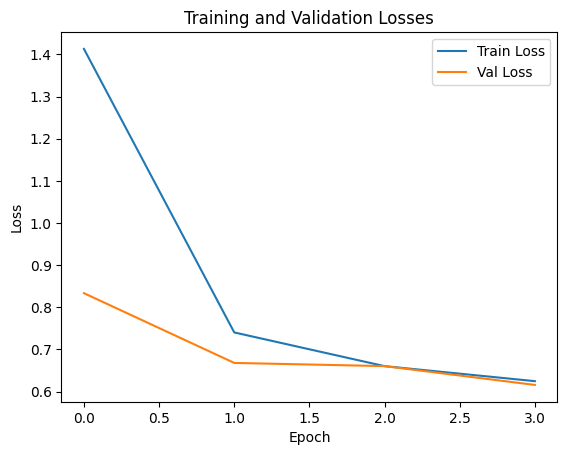

In [12]:
# Initialize models
dilated_unet_model = DilatedUNet(7)
unet_model = UNet(7)

# Train Dilated UNet model
print("Training Dilated UNet model...")
train_model(dilated_unet_model, train_loader, val_loader)

# Train UNet model
print("Training UNet model...")
train_model(unet_model, train_loader, val_loader)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() 
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad(): 
        for batch in test_loader:  # Use test_loader instead of val_loader
            inputs = batch['image'].to(device)
            labels = batch['inst_map'].to(device)

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss (if needed)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item() * inputs.size(0) 

            _, predicted = torch.max(outputs, 1)  
            
            # Calculate accuracy
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Evaluate Dilated UNet model
print("Evaluating Dilated UNet model on test set...")
evaluate_model(dilated_unet_model, test_loader)

# Evaluate UNet model
print("Evaluating UNet model on test set...")
evaluate_model(unet_model, test_loader)


Evaluating Dilated UNet model on test set...


RuntimeError: input and target batch or spatial sizes don't match: target [25, 300, 300], input [25, 7, 212, 212]